<a href="https://colab.research.google.com/github/cerasole/EnvironmentalRadioactivity/blob/main/Notebooks/SpectralFit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install iminuit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.3/439.3 kB 13.5 MB/s eta 0:00:00


In [10]:
import os, glob
import glob
import numpy as np

# Funzioni per la visualizzazione
import matplotlib.pyplot as plt
plt.rc("font", size = 16)

# Funzioni per i fit
from iminuit import Minuit
from iminuit.cost import LeastSquares

In [9]:
!wget https://raw.githubusercontent.com/cerasole/EnvironmentalRadioactivity/main/Data/Posto1/1.txt
!wget https://raw.githubusercontent.com/cerasole/EnvironmentalRadioactivity/main/Data/Posto1/2.txt
!wget https://raw.githubusercontent.com/cerasole/EnvironmentalRadioactivity/main/Data/Posto1/3.txt
!wget https://raw.githubusercontent.com/cerasole/EnvironmentalRadioactivity/main/Data/Posto1/4.txt
!wget https://raw.githubusercontent.com/cerasole/EnvironmentalRadioactivity/main/Data/Posto1/5.txt

--2025-01-04 20:21:06--  https://raw.githubusercontent.com/cerasole/EnvironmentalRadioactivity/main/Data/Posto1/1.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66469 (65K) [text/plain]
Saving to: ‘1.txt.1’

1.txt.1             100%[===================>]  64.91K  --.-KB/s    in 0.008s  

2025-01-04 20:21:06 (8.16 MB/s) - ‘1.txt.1’ saved [66469/66469]

--2025-01-04 20:21:06--  https://raw.githubusercontent.com/cerasole/EnvironmentalRadioactivity/main/Data/Posto1/2.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67111 (66K)

In [13]:
files = glob.glob("*.txt")
files

['1.txt', '4.txt', '2.txt', '5.txt', '3.txt']

In [14]:
Nfiles = 5
for i in range(1, 6):
  file = files[i-1]
  print (file)

1.txt
4.txt
2.txt
5.txt
3.txt


In [18]:
file = files[0]

adc, counts = np.loadtxt(file, unpack = True, skiprows = 14)
adc, counts

(array([0.000e+00, 1.000e+00, 2.000e+00, ..., 8.189e+03, 8.190e+03,
        8.191e+03]),
 array([0., 0., 0., ..., 0., 0., 0.]))

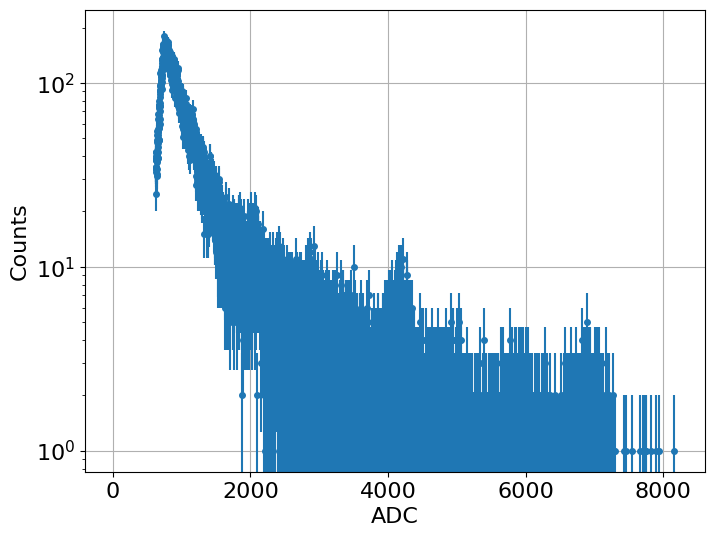

In [32]:
fig, ax = plt.subplots(figsize = (8, 6))

ax.errorbar(
    adc,
    counts,
    xerr = (adc[1] - adc[0])/2,
    yerr = np.sqrt(counts),
    ls = "None",
    marker = "o",
    markersize = 4
)
ax.set_xlabel("ADC")
ax.set_ylabel("Counts")
ax.set_yscale("log")
ax.grid()

In [44]:
### Conteggio totale!

np.sum(counts)

79324.0

In [41]:
# Questa è la funzione che mi è stata suggerita dall'AI di Colab
def rebin_histogram (bins, values, rebin):
  new_bins = bins[::rebin]
  new_values = np.sum(values.reshape(-1, rebin), axis = 1)
  return new_bins, new_values

# Questa è la funzione che scriverei io!
def rebin_histogram(bins, values, rebin):
  N = len(bins)
  new_N = int(N // rebin)
  new_bins, new_values = np.zeros(new_N), np.zeros(new_N)
  for i in range(new_N):
    new_bins[i] = np.mean(bins[i*rebin:(i+1)*rebin])
    new_values[i] = np.sum(values[i*rebin:(i+1)*rebin])
  return new_bins, new_values

rebinned_adc, rebinned_counts = rebin_histogram(adc, counts, 16)

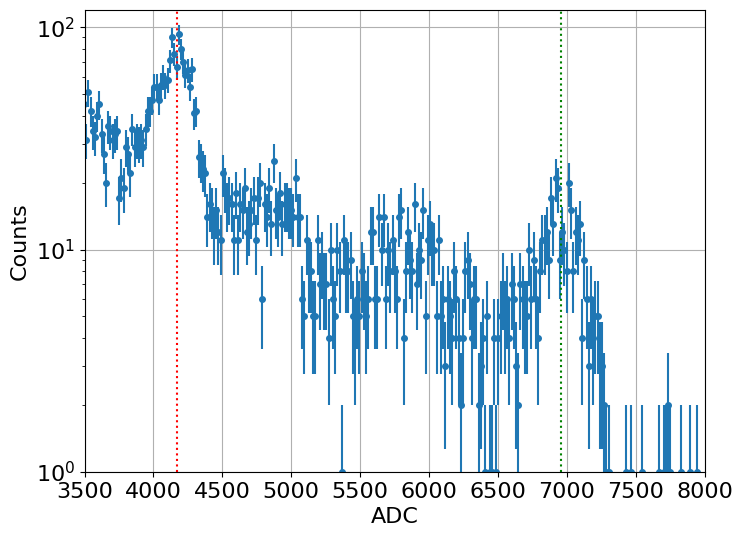

In [64]:
fig, ax = plt.subplots(figsize = (8, 6))

ax.errorbar(
    rebinned_adc,
    rebinned_counts,
    xerr = (rebinned_adc[1] - rebinned_adc[0])/2,
    yerr = np.sqrt(rebinned_counts),
    ls = "None",
    marker = "o",
    markersize = 4
)
ax.set_xlabel("ADC")
ax.set_ylabel("Counts")
ax.set_yscale("log")
# Focus su alcuni picchi a bassa energia
#ax.set_xlim(1000, 3300)
#ax.set_ylim(50, 1000)
ax.axvline(1440, ls = "dotted", color = "gray") # Picco del Pb-214 a 352 keV
ax.axvline(2090, ls = "dotted", color = "purple") # Picco del Tl-208 a 609 keV
# Focus su alcuni picchi ad alta energia
ax.set_xlim(3500, 8000)
ax.set_ylim(1, 120)
ax.axvline(4170, ls = "dotted", color = "red") # Picco del Co-60 a 1460 keV
ax.axvline(6960, ls = "dotted", color = "green") # Picco del Tl-208 o 2614 keV
ax.grid()

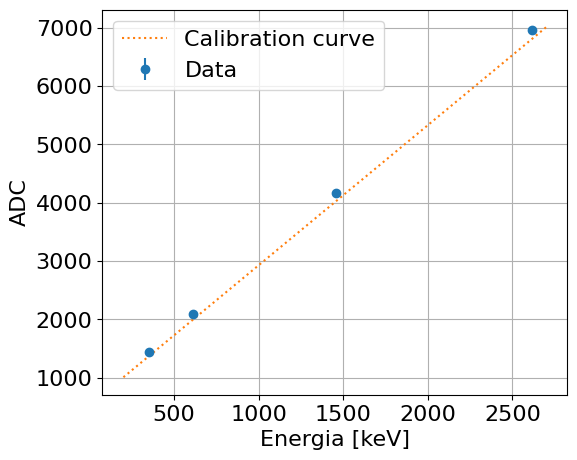

In [70]:
# Calibrazione = conversione da ADC ad energia
adc_peaks = np.array([1440, 2090, 4170, 6960])
adc_peaks_err = np.array([10, 20, 30, 40])
keV_peaks = np.array([352, 609, 1460, 2614])

fig, ax = plt.subplots(figsize = (6, 5))

x = np.linspace(200, 2700)
p0, p1 = 528, 2.4
y = p0 + p1*x

ax.errorbar(
    keV_peaks,
    adc_peaks,
    yerr = adc_peaks_err,
    ls = "None",
    marker = "o",
    label = "Data"
)
ax.plot(x, y, ls = "dotted", label = "Calibration curve")
ax.legend()
plt.xlabel("Energia [keV]")
plt.ylabel("ADC")
plt.grid();

In [78]:
def linear_function (x, p0, p1):
  return p0 + p1*x

loss = LeastSquares(x=keV_peaks, y=adc_peaks, yerror=adc_peaks_err, model = linear_function)
m = Minuit(loss, p0=528, p1=2.4)
m.migrad()
m.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.358 (χ²/ndof = 0.7)      │              Nfcn = 41               │
│ EDM = 1.3e-18 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ p0   │    583    │    12     │            │            │         │         │       │
│ 1 │ p1   │   2.447   │   0.016   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────────┐
│    │         p0         p1 │
├────┼───────────────────────┤
│ p0 │        156 -146.90e-3 │
│ p1 │ -146.90e-3   0.000252 │
└────┴───────────────────────┘

In [82]:
p0, p1 = m.params[0].value, m.params[1].value

In [85]:
rebinned_energy = (rebinned_adc - p0) / p1

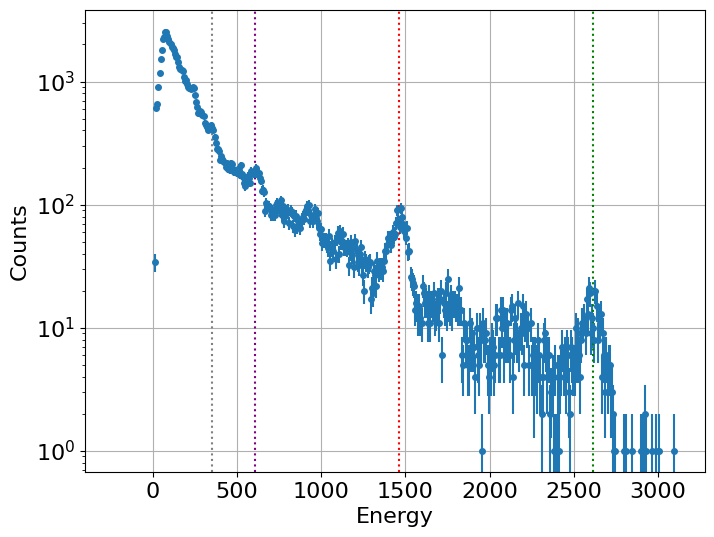

In [87]:
fig, ax = plt.subplots(figsize = (8, 6))

ax.errorbar(
    rebinned_energy,
    rebinned_counts,
    xerr = (rebinned_energy[1] - rebinned_energy[0])/2,
    yerr = np.sqrt(rebinned_counts),
    ls = "None",
    marker = "o",
    markersize = 4
)
ax.set_xlabel("Energy")
ax.set_ylabel("Counts")
ax.set_yscale("log")
# Focus su alcuni picchi a bassa energia
#ax.set_xlim(1000, 3300)
#ax.set_ylim(50, 1000)
ax.axvline(352, ls = "dotted", color = "gray") # Picco del Pb-214 a 352 keV
ax.axvline(609, ls = "dotted", color = "purple") # Picco del Tl-208 a 609 keV
# Focus su alcuni picchi ad alta energia
#ax.set_xlim(3500, 8000)
#ax.set_ylim(1, 120)
ax.axvline(1460, ls = "dotted", color = "red") # Picco del Co-60 a 1460 keV
ax.axvline(2614, ls = "dotted", color = "green") # Picco del Tl-208 o 2614 keV
ax.grid()

In [88]:
### Ora c'è da fare il fit dei picchi con una gaussiana + background esponenziale!